# ASTR 597: Big Data
## Homework 1
Margaret Lazzarini

## Problem #1

### Task 1

Use the schema browser to familiarize yourself with the contents of a view named Star. Then:
Write (and execute) an SQL query to count how many stars have been observed with SDSS (in the current Data Release 12).

The result of my query was 260562744. This means that there are 260,562,744 stars in the SDSS catalogue. I was able to simply use COUNT(objid) because the Star table contains only one observation (the best observation) for each star in the SDSS catalogue.

Write (and execute) an SQL query to count how many observations there are in u, g, r, i and z bands, and the average observed magnitude in each band. How does the SDSS database record missing (magnitude) data?

### Task 2
Write an SQL query to select the positions (α, also known as ra, and δ, also know as dec) and the extinction-corrected (a.k.a. dereddened) g and r-band magnitudes of all stars bounded by 225<α<235 and −2.5<δ<4. Your query should store the outputs into a temporary table in MyDB. Download it as a FITS file. Use the astropy.tables module to load the table data into Python, then store it into a local sqlite database (using Pandas to_sql() functions).

Note: For some reason Cas Jobs was throwing error messages at me that I couldn't quite understand when I tried to download the output of the above query as a FITS file so I downloaded it as a CSV file instead and uploaded that into Python.

In [21]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
from astropy.table import Table, Column

In [63]:
import pandas as pd
import sqlite3

In [62]:
#Import CSV file with output from SQL query on Cas Jobs listed above
stars = Table.read('homework1_sdssdownload.csv')
stars[:10]

g,r,ra,dec
float64,float64,float64,float64
25.42739,24.41125,225.946097744,-1.24556360866
19.80578,19.10279,225.656858294,-1.16785749281
22.84304,22.42121,227.373447658,-1.08865009814
22.74866,21.4418,227.37333578,-1.12405861659
22.34622,21.60957,227.37176664,-1.23958759688
21.79391,21.40178,227.370777832,-1.12864278835
21.63175,21.4657,227.369930137,-1.12972475868
22.81438,21.67926,227.369700277,-1.20227365558
22.36293,21.12169,227.368244757,-1.19140292289


In [93]:
starsdb = Table.to_pandas(stars)

In [94]:
con = sqlite3.connect("starsdb")

In [95]:
starsdb.to_sql('starsdb', con, if_exists='append')

In [96]:
starsdb.dtypes

g      float64
r      float64
ra     float64
dec    float64
dtype: object

In [97]:
starsdb[:10]

,g,r,ra,dec
0,25.42739,24.41125,225.946098,-1.245564
1,19.80578,19.10279,225.656858,-1.167857
2,22.84304,22.42121,227.373448,-1.088650
3,22.74866,21.44180,227.373336,-1.124059
4,22.34622,21.60957,227.371767,-1.239588
5,21.79391,21.40178,227.370778,-1.128643
6,21.63175,21.46570,227.369930,-1.129725
7,22.81438,21.67926,227.369700,-1.202274
8,22.36293,21.12169,227.368245,-1.191403
9,21.82739,20.51520,227.369395,-1.191297


### Task 3
In an IPython notebook, make an ra vs dec scatter plot of the data. Note that the right ascension by convention increases from right to left; make sure your plot reflects that. What do you see near α∼229 and δ∼0? Do know what is this object?

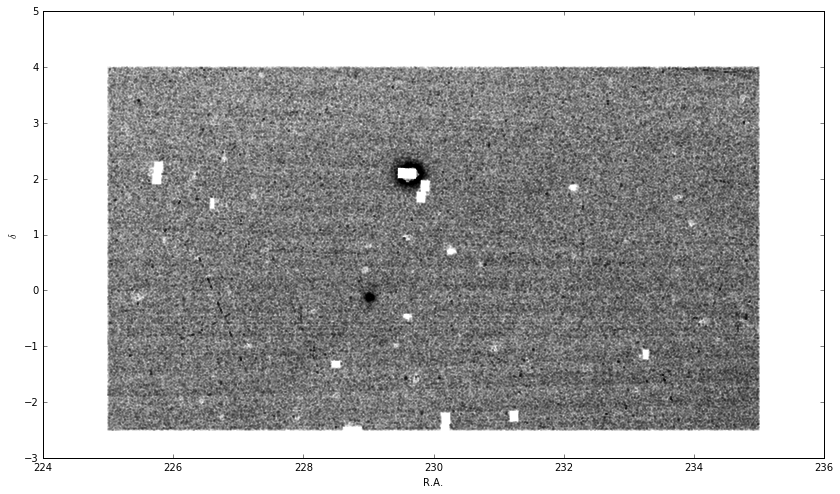

In [99]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(starsdb.ra, starsdb.dec, marker='.', s=0.01)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")

There appears to be a dark portion of the image near (229, 0) and I am honestly not sure what the object is. It looks large on the sky and diffuse, it could be a star cluster or a dwarf galaxy.

### Task 4
Select a subset of the data in a region (a rectangle is fine!) tightly bounding the observed object. Select data in another, equally sized region, nearby but away from the object. Do the selection in two ways: with an SQL query of your local sqlite database, and using the indexing operators in Python (the square brackets '[]'). Show that the two give identical results (it's sufficient to show they return the same number of rows for the same constraints).

In [100]:
#Select using SQL query of local database
sql_result_obj = pd.read_sql("""
    SELECT
        starsdb.ra, starsdb.dec, starsdb.g, starsdb.r
    FROM
        starsdb
    WHERE
        (ra < 229.5) and (ra > 228.5) and (dec < 0.5) and (dec > -0.5)
""", con)

In [102]:
sql_result_blank = pd.read_sql("""
    SELECT
        starsdb.ra, starsdb.dec, starsdb.g, starsdb.r
    FROM
        starsdb
    WHERE
        (ra < 229.5) and (ra > 228.5) and (dec < -1.0) and (dec > -1.5)
""", con)

In [103]:
#Select the same regions using Python indexing commands
py_result_obj = starsdb[(starsdb['ra'] < 229.5) & (starsdb['ra'] > 228.5) & (starsdb['dec'] < 0.5) & (starsdb['dec'] > -0.5)]

In [104]:
py_result_blank = starsdb[(starsdb['ra'] < 229.5) & (starsdb['ra'] > 228.5) & (starsdb['dec'] < -1.0) & (starsdb['dec'] > -1.5)]

In [105]:
#Compare that both methods give the same results
print 'Number of rows in SQL query for object = ', len(sql_result_obj)
print 'Number of rows in SQL query for blank area = ', len(sql_result_blank)
print 'Number of rows in Python query for object = ', len(py_result_obj)
print 'Number of rows in Python query for blank area = ', len(py_result_blank)

Number of rows in SQL query for object =  19730
Number of rows in SQL query for blank area =  8039
Number of rows in Python query for object =  19730
Number of rows in Python query for blank area =  8039


The results above show that the number of rows returned by the SQL query is the same as the number of rows returned by the Python indexing command are the same. The same constraints were used for both queries.

### Task 5
Make two side-by-side scatter plots of the (dereddened) g−r color vs g-band magnitude. Note that the magnitude axis, by convention, always increases from top to bottom; make sure your plot reflects that. Compare the two and describe what you see.

In [106]:
def add_cmd(ax, data):
    g = data['g']
    r = data['r']
    gr = g - r

    ax.scatter(gr, r, marker='.', s = 0.1)

    ax.set_xlim(-1, 2.5)
    ax.set_ylim(15, 22)

    ax.invert_yaxis()

    ax.set_xlabel("g - r")
    ax.set_ylabel("r")

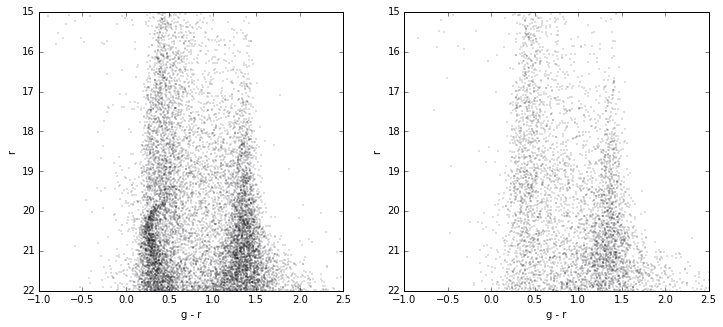

In [109]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
add_cmd(ax[0], py_result_obj)
add_cmd(ax[1], py_result_blank)

The plot on the left shows the portion of the sky with the object in it and the plot on the right shows the portion of the sky that is near but not containing the object. The cmd of the object shows a feature that looks like a stream of stars leaving the main sequence. This shows that a large group of stars within the rectangle I selected are the same age indicating that there is a cluster present that were all born at the same time, most likely a globular cluster given the number of stars present in the feature.

### Task 6
Identify a region in g−r vs g plot where the difference between the two plots appears greatest. From your original sample, select stars only present in that color-magnitude box, and plot them in ra vs dec scatter plot. Do you notice anything interesting?

The region in the CMD that appears to have the most difference is between a g-r value of 0.0 and 0.75 and between an r value of 22 and 19.5 . This is the region I will select to plot in RA and DEC.

In [111]:
#Select the color-magnitude box
cmdbox_obj = py_result_obj[(py_result_obj['r'] < 22.0) & (py_result_obj['r'] > 19.5) & ((py_result_obj['g']-py_result_obj['r']) < 0.75) & ((py_result_obj['g']-py_result_obj['r']) > 0.0)]
cmdbox_blank = py_result_blank[(py_result_blank['r'] < 22.0) & (py_result_blank['r'] > 19.5) & ((py_result_blank['g']-py_result_blank['r']) < 0.75) & ((py_result_blank['g']-py_result_blank['r']) > 0.0)]

In [112]:
#Plot these color-magnitude boxes in RA vs. DEC scatter plots.
def add_scatter(ax, data):
    ra = data['ra']
    dec = data['dec']

    ax.scatter(ra, dec, marker='.', s = 0.1)

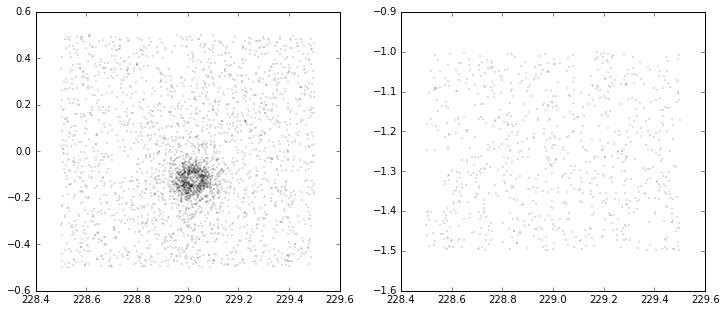

In [113]:
fig, ax = plt.subplots(ncols=2, figsize = (12,5))
add_scatter(ax[0], cmdbox_obj)
add_scatter(ax[1], cmdbox_blank)

From the plots above I clearly see a tight grouping of stars in the middle of the "object" color-magnitude box and an even distribution of stars everywhere in the "blank" color-magnitude box. This further confirms that the object creating the feature in the CMD is a globular cluster.

## Problem 2

In [23]:
#Import LSD
from lsd import DB
from lsd.bounds import beam, rectangle

In [24]:
#Setting LSD parameters
import os
os.environ['NWORKERS'] = '8'
os.environ['LSD_CACHEDIR'] = os.environ['HOME'] + '/tempdir'
os.environ['LSD_TEMPDIR'] = os.environ['HOME'] + '/tempdir'
os.environ['LSD_DB'] = os.environ['HOME'] + '/lsddb:/astro/apps6/opt/lsddb'

In [25]:
#Double checking environmental parameters
print os.environ['NWORKERS']
print os.environ['LSD_DB']
print os.environ['LSD_CACHEDIR']
print os.environ['LSD_TEMPDIR']

8
/astro/users/mlazz/lsddb:/astro/apps6/opt/lsddb
/astro/users/mlazz/tempdir
/astro/users/mlazz/tempdir


In [26]:
#Creating the table using the YAML file I created
! lsd-admin create table --schema hw1_sdss.yaml sdss_stars_sweep --drop-existing

Table 'sdss_stars_sweep' dropped.

-------- committing 20160217233722.985847 [sdss_stars_sweep] ---------
[sdss_stars_sweep] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.28 sec
[sdss_stars_sweep] Updating neighbors: Already up to date.
[sdss_stars_sweep] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.23 sec
[sdss_stars_sweep] Updating stats: [0 el.]>  0.00 sec
[sdss_stars_sweep] Marking tablets read-only...
----------- success 20160217233722.985847 [sdss_stars_sweep] ---------

Table 'sdss_stars_sweep' created.


In [27]:
#Importing the table
! lsd-import fits sdss_stars_sweep 'calibObj-000094-1-star.fits' 'calibObj-000094-2-star.fits' 'calibObj-000094-3-star.fits' 'calibObj-000094-4-star.fits' 'calibObj-000094-5-star.fits'

Importing from 5 pieces:
  ===> Imported calibObj-000094-5-star.fits                                            [1/5, 20.00%] + 136292/136292     136292 (0/2 min.)
  ===> Imported calibObj-000094-4-star.fits                                            [2/5, 40.00%] + 130027/130027     266319 (0/1 min.)
  ===> Imported calibObj-000094-1-star.fits                                            [3/5, 60.00%] + 133515/133515     399834 (0/1 min.)
  ===> Imported calibObj-000094-2-star.fits                                            [4/5, 80.00%] + 155355/155355     555189 (0/0 min.)
  ===> Imported calibObj-000094-3-star.fits                                            [5/5, 100.00%] + 124832/124832     680021 (0/0 min.)
done

-------- committing 20160217233750.727828 [sdss_stars_sweep] ---------
[sdss_stars_sweep] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.40 sec
[sdss_stars_sweep] Updating neighbors: [48 el.]::::::::::::::::::::[118 el.]++++++++++++++++++++>  8.09 sec
         

In [116]:
#Here I imported one of the fits files from run 94 so that I could inspect the column titles and data types
t = Table.read('/astro/users/mlazz/astr597b_wi16/calibObj-000094-1-star.fits')
t[:10]

RUN,RERUN,CAMCOL,FIELD,ID,OBJC_TYPE,OBJC_FLAGS,OBJC_FLAGS2,OBJC_ROWC,ROWVDEG,ROWVDEGERR,COLVDEG,COLVDEGERR,ROWC [5],COLC [5],M_RR_CC [5],M_RR_CC_PSF [5],FLAGS [5],FLAGS2 [5],PSP_STATUS [5],RA,DEC,PSF_FWHM [5],EXTINCTION [5],SKYFLUX [5],PSFFLUX [5],PSFFLUX_IVAR [5],FIBERFLUX [5],FIBERFLUX_IVAR [5],FIBER2FLUX [5],FIBER2FLUX_IVAR [5],MODELFLUX [5],MODELFLUX_IVAR [5],CALIB_STATUS [5],NMGYPERCOUNT [5],RESOLVE_STATUS,THING_ID,IFIELD,BALKAN_ID,NDETECT,PM_MATCH,PMRA,PMDEC,PMRAERR,PMDECERR,PM_SIGRA,PM_SIGDEC,PM_NFIT,PM_DIST22,TMASS_J,TMASS_J_IVAR,TMASS_H,TMASS_H_IVAR,TMASS_K,TMASS_K_IVAR,TMASS_PH_QUAL,TMASS_RD_FLG,TMASS_BL_FLG,TMASS_CC_FLG,TMASS_GAL_CONTAM,TMASS_MP_FLG,TMASS_HEMIS,TMASS_JDATE,APERFLUX6 [5],ZHEDFLAG,CMODELFLUX_CLEAN [5],CMODELFLUX_CLEAN_IVAR [5],CMODELFLUX_CLEAN_VAR [5],CMODELFLUX_CLEAN_CHI2 [5],CMODEL_CLEAN_NUSE [5],CMODEL_CLEAN_MJD_MAXDIFF [5],CMODEL_CLEAN_MJD_VAR [5],MODELFLUX_CLEAN [5],MODELFLUX_CLEAN_IVAR [5],MODELFLUX_CLEAN_VAR [5],MODELFLUX_CLEAN_CHI2 [5],MODEL_CLEAN_NUSE [5],MODEL_CLEAN_MJD_MAXDIFF [5],MODEL_CLEAN_MJD_VAR [5],PSFFLUX_CLEAN [5],PSFFLUX_CLEAN_IVAR [5],PSFFLUX_CLEAN_VAR [5],PSFFLUX_CLEAN_CHI2 [5],PSF_CLEAN_NUSE [5],PSF_CLEAN_MJD_MAXDIFF [5],PSF_CLEAN_MJD_VAR [5]
int16,str3,uint8,int16,int16,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int32,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,str3,int16,int16,str3,uint8,uint8,str1,float64,float32,int16,float32,float32,float32,float32,int16,int32,float32,float32,float32,float32,float32,int16,int32,float32,float32,float32,float32,float32,int16,int32,float32
94,301,1,11,8,6,270405908,90128,68.4857,0.0,-9999.0,0.0,-9999.0,75.1084 .. 78.1678,1928.82 .. 1925.59,-9999.0 .. -9999.0,5.98224 .. 5.84239,143036689 .. 143036689,2097152 .. 2097152,32 .. 0,336.440207689,-0.832504704758,1.61203 .. 1.5933,0.340334 .. 0.0976439,4.68171 .. 46.6356,-6.82922e-05 .. 8.35128e-05,0.666795 .. 0.0644177,17.2799 .. 46.5447,0.743652 .. 0.060131,7.39309 .. 19.5926,1.71114 .. 0.139154,-1.39955e-05 .. -4.51943e-05,0.622507 .. 0.0401156,1 .. 1,0.0073679 .. 0.0339998,513,76284073,0,3117269,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,10.4232,0.0,0.0,0.0,0.0,0.0,0.0,,0,0,,0,0,,0.0,3.75877e-05 .. 0.000173452,1,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0
94,301,1,11,17,6,303960340,110592,164.441,-9999.0,-9999.0,-9999.0,-9999.0,171.39 .. 174.165,2011.5 .. 2008.23,-9999.0 .. 1.79438,5.98224 .. 5.84239,143003921 .. 302120976,2097152 .. 1085504,32 .. 0,336.450753779,-0.823409731508,1.61203 .. 1.5933,0.335409 .. 0.0962309,1.89106 .. 39.7543,-0.167219 .. 8.16879,14.4011 .. 0.112128,0.102648 .. 6.93171,14.6958 .. 0.238195,-0.0129947 .. 4.22213,32.9837 .. 0.418938,-0.175841 .. 7.79351,14.2652 .. 0.426246,1 .. 1,0.0074081 .. 0.0339828,17,-1,0,3117266,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0,0,,0,0,,0.0,-49184.9 .. -225617.0,1,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0
94,301,1,11,19,6,303960340,73744,103.964,0.0,-9999.0,0.0,-9999.0,110.706 .. 113.829,2012.22 .. 2009.05,-9999.0 .. -9999.0,5.98224 .. 5.84239,176615697 .. 143036689,2097152 .. 2097152,32 .. 0,336.444103506,-0.823348827743,1.61203 .. 1.5933,0.337718 .. 0.0968934,1.92024 .. 39.4882,0.037068 .. -0.38407,14.2022 .. 0.465661,0.00274229 .. -0.982647,14.4043 .. 0.495504,0.00817774 .. -0.496149,32.614 .. 1.11488,0.0273573 .. -0.372584,13.3108 .. 0.433883,1 .. 1,0.0074091 .. 0.0339827,17,-1,0,3117267,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,

In [36]:
#Create a fits file with the footprint of the sdss_stars_sweep table
! lsd-footprint sdss_stars_sweep foot.fits

 [48 el.]::::::::::::::::::::>  4.13 sec
Objects: 680021.0


(2740, 2660)

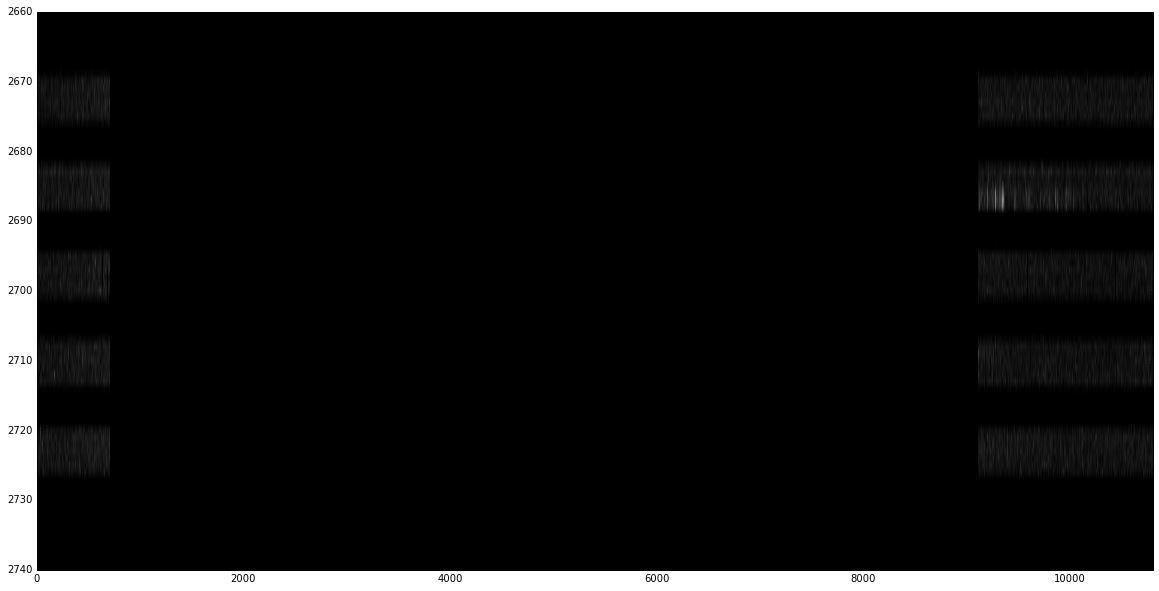

In [57]:
#Plot the foot.fits file that contains the image of the sdss_stars_sweep footprint
import astropy.io.fits as pyfits
footprint = 'foot.fits'
imgdata = pyfits.getdata(footprint)

fig,axes = plt.subplots(figsize=(20,10))
plt.imshow(imgdata, cmap='gray', aspect='auto')
plt.xlim(0, 10800)
plt.ylim(2740, 2660)